In [46]:
import torch
from torch import nn
import numpy as np
import os
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import v2
from utils.graph_utils import lossGraph
%matplotlib inline

SEED = 42
THRESHOLD = 0.5
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 16

DEVICE = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else
  "cpu"
)
print(f"Using {DEVICE} device")

np.random.seed(SEED)

Using cpu device


In [47]:
data_dir = 'data'

In [48]:
transform = v2.Compose([
  v2.Resize(size=(IMAGE_WIDTH, IMAGE_WIDTH)),
  v2.RandomHorizontalFlip(),
  v2.ToImage(), 
  #Scale the image from 0 to 1 (division of 255)
  v2.ToDtype(torch.float32, scale=True) 
])

In [49]:
dataset = datasets.ImageFolder(os.path.join(data_dir), transform=transform)

In [50]:
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [51]:
training_size = int(len(dataset)*0.8) #80% of data
testing_size = len(dataset) - training_size #20% of data
print(f"Dataset Size: {len(dataset)}")
print(f"Training Size: {training_size}")
print(f"Testing Size: {testing_size}")

Dataset Size: 420
Training Size: 336
Testing Size: 84


In [52]:
training_data, testing_data = random_split(dataset, [training_size, testing_size])

In [53]:
train_dataloader = DataLoader(dataset=training_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              drop_last=True)

test_dataloader = DataLoader(dataset=testing_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             drop_last=True)

In [54]:
print(f"train_dataloader iterable length: {len(train_dataloader)}")
print(f"test_dataloader iterable length: {len(test_dataloader)}")

train_dataloader iterable length: 21
test_dataloader iterable length: 5


dataloader size: 336
X shape before: (3, 256, 256)
X shape after: (256, 256, 3)


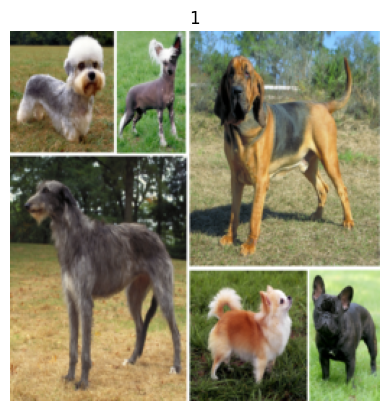

In [55]:
X, y = train_dataloader.dataset[335]
print(f"dataloader size: {len(train_dataloader.dataset)}")
print("X shape before:", X.numpy().shape)

#tranpose((1,2,0)) set index 1 shape to x, set index 2 shape to y, set index 0 shape to z
X = X.numpy().transpose((1, 2, 0)) 
# X = X.squeeze().permute(1,2,0) also works

print("X shape after:", X.shape)

#Must pass dimension in form of (M, N) / (M, N, 3) / (M, N, 4)
plt.imshow(X)
plt.title(y)
plt.axis('off')
plt.show()

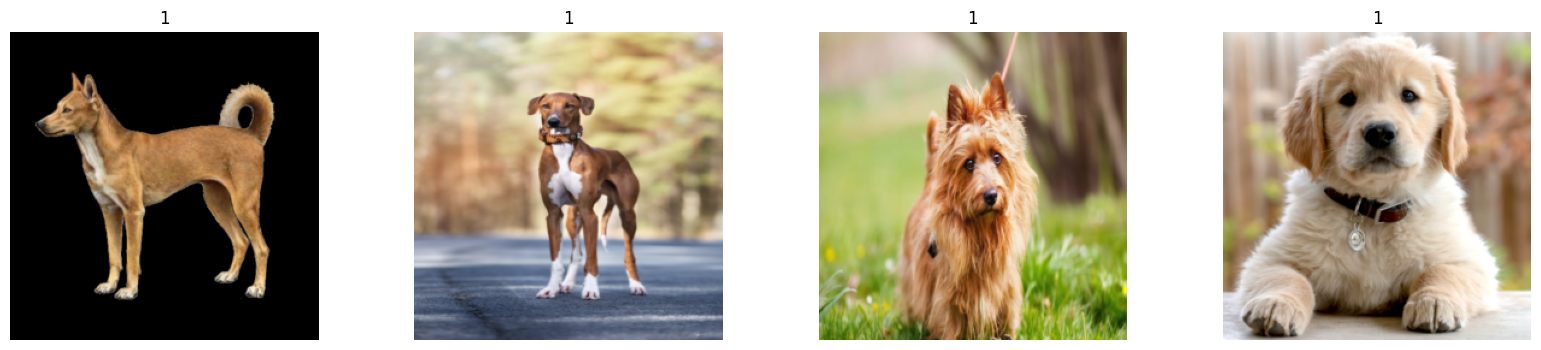

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
for i in range(4):
  X, y = train_dataloader.dataset[i]
  X = X.numpy().transpose((1, 2, 0))
  ax[i].imshow(X)
  ax[i].set_title(y)
  ax[i].axis('off')
plt.show()

In [57]:
for X, y in train_dataloader:
  print(f"[batch_size, channel, height, width]: [{X.shape[0]}, {X.shape[1]}, {X.shape[2]}, {X.shape[3]}]")
  print(f"y shape: {y.shape}")
  break

[batch_size, channel, height, width]: [16, 3, 256, 256]
y shape: torch.Size([16])


In [58]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.conv_stack = nn.Sequential(
      #(256,256,3)
      nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=1),
      #(256,256,16)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2)),
      #(128,128,16)
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=1),
      #(128,128,32)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2)),
      #(64,64,32)
      nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=1),
      #(64,64,16)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2)),
      #(32,32,16)
      nn.Dropout(0.2),
      nn.Flatten(),
      #Input FC layer = 32*32*16
      nn.Linear(16384, 256),
      nn.ReLU(),
      nn.Linear(256, 1)
    )

  def forward(self, x):
    logits = self.conv_stack(x)
    return logits
    
model = NeuralNetwork().to(DEVICE)
print(model)

NeuralNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=16384, out_features=256, bias=True)
    (12): ReLU()
    (13): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [59]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  train_loss, num_correct = 0, 0
  model.train()
  
  for batch, (X, y) in enumerate(dataloader):
    X, y, X.to(DEVICE), y.to(DEVICE)
    y = y.type(torch.float)

    #For unknown reasons, sepreating 'pred' increases accuracy significantly
    pred = model(X).reshape(BATCH_SIZE,)
    pred = nn.Sigmoid()(pred)
    
    loss = loss_fn(pred, y)
    train_loss += loss.item()
    num_correct += ((pred > THRESHOLD) == y).type(torch.float).sum().item()
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 10 == 0:
      loss, current = loss.item(), (batch+1) * len(X)
      print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

  avgTrainingLoss = train_loss / len(dataloader)
  trainingAccuracy = (num_correct / size) * 100
  
  return avgTrainingLoss, trainingAccuracy

In [60]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  number_batches = len(dataloader)

  model.eval()

  test_loss, num_correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      y = y.type(torch.float)
      
      pred = model(X).reshape(BATCH_SIZE,)
      pred = nn.Sigmoid()(pred)

      # print(f"y {y} \n ---------------------------------------------------------------------------")
      # print(f"pred threshold {(pred > THRESHOLD).type(torch.float)} \n ---------------------------------------------------------------------------")
      # print(f"pred same {((pred > THRESHOLD) == y).type(torch.float)} \n --------------------------------------------------------------------------- \n")
      
      test_loss += loss_fn(pred, y).item()
      num_correct += ((pred > THRESHOLD) == y).type(torch.float).sum().item() 

  avgTestingLoss = test_loss / number_batches
  testingAccuracy = (num_correct / size) * 100
  print(f"Test Error --- Accuracy: {testingAccuracy:.1f}%, Avg Loss: {avgTestingLoss:>8f} \n")

  return avgTestingLoss, testingAccuracy

In [61]:
def main(): 
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  epochs = 20
  training_loss, testing_loss = [], []
  training_accuracy, testing_accuracy = [], []

  for t in range(epochs):
    print(f"Epoch {t+1} \n -------------------------------")
    avgTrainingLoss, trainingAccuracy = train(train_dataloader, model, loss_fn, optimizer)
    training_loss.append(avgTrainingLoss)
    training_accuracy.append(trainingAccuracy)

    avgTestingLoss, testingAccuracy = test(test_dataloader, model, loss_fn)
    testing_loss.append(avgTestingLoss)
    testing_accuracy.append(testingAccuracy)
    
  lossGraph(training_loss, testing_loss, training_accuracy, testing_accuracy, epochs)

Epoch 1 
 -------------------------------
Loss: 0.688260 [   16/  336]
Loss: 0.693409 [  176/  336]
Loss: 0.667038 [  336/  336]
Test Error --- Accuracy: 47.6%, Avg Loss: 0.689140 

Epoch 2 
 -------------------------------
Loss: 0.668825 [   16/  336]
Loss: 0.669588 [  176/  336]
Loss: 0.653024 [  336/  336]
Test Error --- Accuracy: 47.6%, Avg Loss: 0.679595 

Epoch 3 
 -------------------------------
Loss: 0.644758 [   16/  336]
Loss: 0.642355 [  176/  336]
Loss: 0.597560 [  336/  336]
Test Error --- Accuracy: 65.5%, Avg Loss: 0.634584 

Epoch 4 
 -------------------------------
Loss: 0.568823 [   16/  336]
Loss: 0.820377 [  176/  336]
Loss: 0.709355 [  336/  336]
Test Error --- Accuracy: 65.5%, Avg Loss: 0.626642 

Epoch 5 
 -------------------------------
Loss: 0.632769 [   16/  336]
Loss: 0.460477 [  176/  336]
Loss: 0.522363 [  336/  336]
Test Error --- Accuracy: 67.9%, Avg Loss: 0.598673 

Epoch 6 
 -------------------------------
Loss: 0.416817 [   16/  336]
Loss: 0.801598 [  1

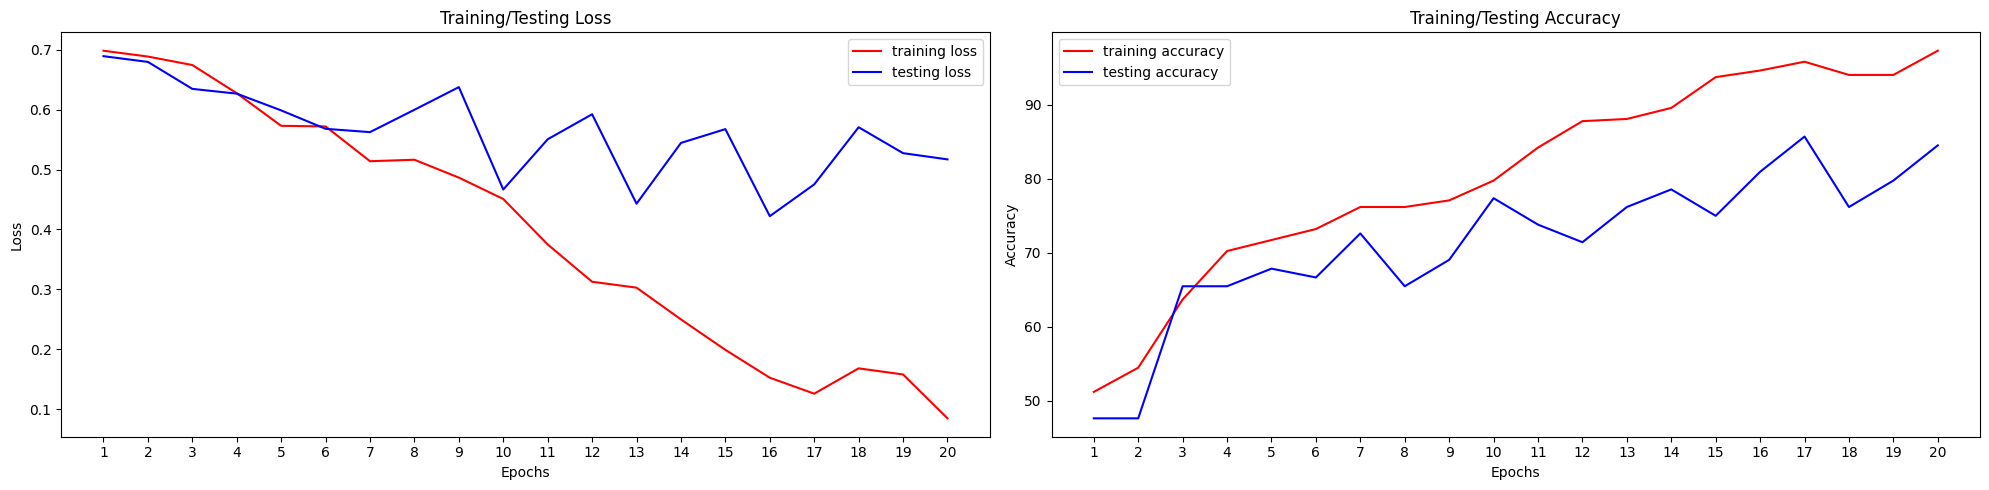

In [62]:
if __name__ == "__main__":
  main()

In [63]:
torch.save(model, "models/pytorchmodels/simplemodel.pth")

In [64]:
"""
Other fixes:

- Overfitted

Part of this code is from Pytorch official website
"""

'\nOther fixes:\n\n- Overfitted\n\nPart of this code is from Pytorch official website\n'